# Imports

In [2]:
import torch
import numpy as np
from torch import autograd
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
import pandas as pd
import math
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

# Global Variables

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Helper Functions

In [4]:
def get_density_chart(P, d=7.0, step=0.1, dist_type=None):
    """
    Given a probability distribution, return a density chart (Heatmap)
    Inputs:
        P: Probability distribution
        d: A value used to bound the meshgrid
        step: A value used in the arange method to create the meshgrid
    Outputs:
        chart: Altair object corresponding to a density plot
    """
    xv, yv = torch.meshgrid([torch.arange(-d, d, step), torch.arange(-d, d, step)])
    pos_xy = torch.cat((xv.unsqueeze(-1), yv.unsqueeze(-1)), dim=-1)
    p_xy = P.log_prob(pos_xy.to(device)).exp().unsqueeze(-1).cpu()


    df = torch.cat([pos_xy, p_xy], dim=-1).numpy()
    df = pd.DataFrame({
        'x': df[:, :, 0].ravel(),
        'y': df[:, :, 1].ravel(),
        'p': df[:, :, 2].ravel(),})

    chart = alt.Chart(df).mark_point().encode(

        x=alt.X('x:Q', axis=alt.Axis(title='', labelFontSize=20, tickSize=12)),
        y=alt.Y('y:Q', axis=alt.Axis(title='', labelFontSize=20, tickSize=12)),
        color=alt.Color('p:Q', scale=alt.Scale(scheme='lightorange')),
        tooltip=['x','y','p']).properties(
        width=220,
        height=190
    )


    return chart



def get_particles_chart(X, X_svgd=None):
    """
    Given a set of points, return a scatter plot
    Inputs:
        X: Final positions of the particles after applying svgd
        X_svgd: Intermidiate position of the particles while applying svgd. If None do not add them to the plot
    Outputs:
        chart: Altair object corresponding to a scatter plot
    """
    df = pd.DataFrame({
        'x': X[:, 0],
        'y': X[:, 1],})

    chart = alt.Chart(df).mark_circle(color='black').encode(x='x:Q',y='y:Q')

    if X_svgd is not None:
        for i in range(np.shape(X_svgd)[1]):
            df_trajectory = pd.DataFrame({'x': X_svgd[:,i,0],'y': X_svgd[:,i,1],})
            chart += alt.Chart(df_trajectory).mark_line().mark_circle(color='green').encode(x='x:Q',y='y:Q')

    return chart


def filter(results, constraints):
    """
    Given a dictionary of experiments results, search it given a list of constraints
    Inputs:
        results: A dictionary of experimental results
        constraints: A list of configuration constraints
    Outputs:
        Elements based on the input configurations of experiments 
    """
    configs = []
    for i in range(len(results['configs'])):
        check_bool = True
        for j in range(len(results['configs'][i])):
            if constraints[j] == '*':
                continue
            if results['configs'][i][j] != constraints[j]:
                check_bool = False
                break
        if check_bool:
            configs.append(i)
        
    return np.array(results['sampler_entr_svgd'])[configs].tolist(), np.array(results['gt_entr'])[configs].tolist(), np.array(results['charts_svgd'])[configs].tolist(), np.array(results['init_chart'])[configs].tolist()

def figure_4c(results, mu, sigma, figure_name='figure_4c'):
    """
    Create figure 4c in the paper
    Inputs:
        results: Dictionary containing all the saved data
        mu: Mean of the initial distribution
        sigma: Standard deviation of the initial distribution
        figure_name: Figure name
    """

    x_values = ['0.1', '1', '3', '5', '7', '10', '100']
    entropies, gt_entr, charts, init_charts = filter(results, ['*', '*', '*', '*', 200, 200, '*' , mu, sigma])
    dis_200s_200p = entropies
    entropies, gt_entr, charts, init_charts = filter(results, ['*', '*', '*', '*', 100, 100, '*' , mu, sigma])
    dis_100s_100p = entropies
    entropies, gt_entr, charts, init_charts = filter(results, ['*', '*', '*', '*', 10, 20, '*' , mu, sigma])
    dis_20s_10p = entropies
    entropies, gt_entr, charts, init_charts = filter(results, ['*', '*', '*', '*', 20, 20, '*' , mu, sigma])
    dis_20s_20p = entropies

    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(8, 5))
    plt.scatter(x_values, dis_200s_200p, marker="o", label="200", s=60 )
    plt.scatter(x_values, dis_100s_100p, marker="s", label="100", s=60 )
    plt.scatter(x_values, dis_20s_20p, marker="P", label="20", s=60 )
    plt.scatter(x_values, dis_20s_10p, marker="*", label="10", s=60 )
    plt.axhline(y = np.mean(gt_entr), color = 'g', linestyle = 'dotted')
    plt.legend(title="# particles", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Kernel variance")
    plt.ylabel(r"$H(q^L)$")
    plt.ylim(0, 5)
    plt.savefig('./' + figure_name + '.pdf', bbox_inches='tight')
    plt.show()

def figure_4b(results, dims, expr_name, x_label, x_ticks, results_tmp=None, results_200=None, resutls_500=None):
    """
    Create figure 4b from the paper
    Inputs:
        results: Dictionary containing all the results' data
        dims: A list containing the dimensions we want to print
        expr_name: Experiment name
        x_label: X axis label
        x_ticks: X axis ticks
    """

    for dim in dims:
        filtered_results = [filter(results[i][expr_name], [dim, '*', '*', '*', 10, 20, '*' , 0, 6]) for i in range(len(results))]
        gmm1_20s_10p = [filtered_results[i][0] for i in range(len(filtered_results))]

        if results_tmp == None:
            filtered_results = [filter(results[i][expr_name], [dim, '*', '*', '*', 10, 10, '*' , 0, 6]) for i in range(len(results))]
        else:
            filtered_results = [filter(results_tmp[i][expr_name], [dim, '*', '*', '*', 10, 10, '*' , 0, 6]) for i in range(len(results_tmp))]
        gmm1_10s_10p = [filtered_results[i][0] for i in range(len(filtered_results))]
        if results_200 == None:
            filtered_results = [filter(results[i][expr_name], [dim, '*', '*', '*', 200, 200, '*' , 0, 6]) for i in range(len(results))]
        else:
            filtered_results = [filter(results_200[i][expr_name], [dim, '*', '*', '*', 200, 200, '*' , 0, 6]) for i in range(len(results_200))]
        gmm1_200s_200p = [filtered_results[i][0] for i in range(len(filtered_results))]

        if results_500 == None:
            filtered_results = [filter(results[i][expr_name], [dim, '*', '*', '*', 200, 500, '*' , 0, 6]) for i in range(len(results))]
        else:
            filtered_results = [filter(resutls_500[i][expr_name], [dim, '*', '*', '*', 200, 200, '*' , 0, 6]) for i in range(len(resutls_500))]
        gmm1_500s_200p = [filtered_results[i][0] for i in range(len(filtered_results))]
        
        
        raw_mean = [list(np.nanmean(gmm1_20s_10p, axis=0)), list(np.nanmean(gmm1_10s_10p, axis=0)), list(np.nanmean(gmm1_200s_200p, axis=0)), list(np.nanmean(gmm1_500s_200p, axis=0))]
        raw_std = [list(np.nanstd(gmm1_20s_10p, axis=0)), list(np.nanstd(gmm1_10s_10p, axis=0)), list(np.nanstd(gmm1_200s_200p, axis=0)), list(np.nanstd(gmm1_500s_200p, axis=0))]
        colors = ['r', 'g', 'b', 'k']
        labels = ['#(p,s): (10,20) ', '#(p,s): (10,10) ', '#(p,s): (200,200) ', '#(p,s): (200,500) ']
        plt.figure(figsize=(8, 6), dpi=150)
        plt.xlabel(x_label)
        plt.ylabel("Entropy")
        for i in range(len(raw_mean)):
            plt.errorbar(np.array([0.0, 1.0, 2.0, 3.0]), raw_mean[i], yerr=raw_std[i], color=colors[i], marker='o', label=labels[i])
        plt.xticks(np.array([0.0, 1.0, 2.0, 3.0]), np.array(x_ticks))
        plt.xlim([-0.5, 3.5])
        plt.title('dim_' + str(dim))
        plt.legend()
        plt.savefig('./' + expr_name + '_' + str(dim) + '.png', bbox_inches='tight')


# Kernel

In [5]:
class RBF:
    """
    Radial basis funtion kernel (https://en.wikipedia.org/wiki/Radial_basis_function)
    Inputs:
        sigma: Kernel standard deviation 
        num_particles: Number of particles
    """
    def __init__(self, sigma, num_particles):
        self.sigma = sigma
        self.num_particles = num_particles

    def forward(self, input_1, input_2):
        """
        Given two tensors of particles, return the matrix of distances between each particle
        Inputs:
            input_1: Particles coordinates
            input_2: Particles coordinates
        Outputs:
            kappa: RBF matrix 
            diff: Signed distance 
            h: Kernel variance
            kappa_grad: Derivative of rbf kernel
            gamma: 1/2*sigma**2
        """
        # Check if the inputs have the same size in the last two dimensions
        assert input_2.size()[-2:] == input_1.size()[-2:]
        
        # Compute the difference between each particle
        diff = input_1.unsqueeze(-2) - input_2.unsqueeze(-3)
        # Square the difference and sum over the particle's dimensions
        dist_sq = diff.pow(2).sum(-1)
        dist_sq = dist_sq.unsqueeze(-1)
        
        if self.sigma == "mean":
            # Estimate the kernel variance using the mean of all the particles distances
            median_sq = torch.mean(dist_sq.detach().reshape(-1, self.num_particles*self.num_particles), dim=1)
            median_sq = median_sq.unsqueeze(1).unsqueeze(1)
            h = median_sq / (2 * np.log(self.num_particles + 1.))
            sigma = torch.sqrt(h)
        elif self.sigma == "forth":
            # Estimate the kernel variance using the mean devided by two (one forth) of all the particles distances
            median_sq = 0.5 * torch.mean(dist_sq.detach().reshape(-1, self.num_particles*self.num_particles), dim=1)
            median_sq = median_sq.unsqueeze(1).unsqueeze(1)
            h = median_sq / (2 * np.log(self.num_particles + 1.))
            sigma = torch.sqrt(h)
        elif self.sigma == "median":
            # Estimate the kernel variance using the median of all the particles distances
            median_sq = torch.median(dist_sq.detach().reshape(-1, self.num_particles*self.num_particles), dim=1)[0]
            median_sq = median_sq.unsqueeze(1).unsqueeze(1)
            h = median_sq / (2 * np.log(self.num_particles + 1.))
            sigma = torch.sqrt(h)
        else:
            # Setting the kernel variance from the input 
            sigma = self.sigma
            h = None
        
        gamma = 1.0 / (1e-8 + 2 * sigma**2) 
        
        kappa = (-gamma * dist_sq).exp() 
        # Computing the gradient of the kernel over the particles
        kappa_grad = -2. * (diff * gamma) * kappa
        return kappa.squeeze(), diff, h, kappa_grad, gamma


# GMM

In [6]:

class GMMDist(object):
    """
    Gaussian Mixture Model
    Inputs:
        dim: Number of dimensions of the random variable
        n_gmm: Number of mixtures
        sigma: Mixutures' standard diviation
    """
    def __init__(self, dim, n_gmm, sigma):
        def _compute_mu(i):
            """
            Compute the mean of each mixture
            Inputs:
                i: Index of the mixture
            Outputs:
                The mean of each dimension of the random variable
            """
            return 4 * torch.Tensor([[torch.tensor(i * math.pi / (n_gmm/2)).sin(),torch.tensor(i * math.pi / (n_gmm/2)).cos()] + [torch.rand((1,)) * 2 - 1 for _ in range(dim - 2)]])
        
        # Generate a list of equal probabilities between the mixtures
        self.mix_probs = (1.0/n_gmm) * torch.ones(n_gmm).to(device)
        # Compute the means
        self.means = torch.cat([_compute_mu(i) for i in range(n_gmm)], dim=0).to(device)
        # Compute the standard deviations
        self.sigma = sigma
        self.std = torch.stack([torch.ones(dim).to(device) * self.sigma for i in range(len(self.mix_probs))], dim=0)
        
        
    def sample(self, n):
        """
        Sample a tensor of particles
        Inputs:
            n: Number of particles
        Outputs:
            A tensor of particles that follows this distribution
        """
        mix_idx = torch.multinomial(self.mix_probs, n[0], replacement=True)
        means = self.means[mix_idx]
        stds = self.std[mix_idx]
        return torch.randn_like(means) * stds + means

    def log_prob(self, samples):
        """
        Given a tensor of particles, compute their log probability with respect to the current distribution 
        (the mixtures are independent)
        Inputs:
            samples: A tensor of particles
        Outputs:
            A tensor of log probabilites
        """
        logps = []
        for i in range(len(self.mix_probs)):
            logps.append((-((samples.to(device) - self.means[i]) ** 2).sum(dim=-1) / (2 * self.sigma ** 2) - 0.5 * np.log(
                2 * np.pi * self.sigma ** 2)) + self.mix_probs[i].log())
        logp = torch.logsumexp(torch.stack(logps, dim=0), dim=0)
        return logp


# Optimizer

In [7]:

class Optim():
    """
    Optimizer Class 
    Inputs:
        lr: Learning rate
    """
    def __init__(self, lr=None):
        self.m_dx, self.v_dx = 0, 0
        self.lr = lr
    
    def step(self,x, dx): 
        """
        Gradient Ascent
        Inputs:
            x: A tensor of particles
            dx: The update vector
        Outputs:
            x: Updated particles
        """
        dx = dx.view(x.size())
        x = x + self.lr * dx 
        return x


# Entropy Computation

In [8]:

class Entropy():
    """
    Entropy Class 
    Inputs:
        P: GMM Object
        K: RBF Kernel
        optimizer: Gradient Ascent optimizer
        num_particles: Number of particles
        particles_dim: Particles' number of dimensions 
    """
    def __init__(self, P, K, optimizer, num_particles, particles_dim):
        self.P = P
        self.optim = optimizer
        self.num_particles = num_particles
        self.particles_dim = particles_dim
        self.K = K

        # Mean of Langevin dynamics initial distribution
        mu_ld_noise = torch.zeros((self.particles_dim,)) 
        # Standard deviation of Langevin dynamics initial distribution
        sigma_ld_noise = torch.eye(self.particles_dim) * 0.05
        # Langevin dynamics initial distribution
        self.init_dist_ld = torch.distributions.MultivariateNormal(mu_ld_noise,covariance_matrix=sigma_ld_noise)
        # Identity matrix used in the computation of the entropy (line 1)
        self.identity_mat = torch.eye(self.particles_dim).to(device)
        # Identity matrix used in the computation of the entropy (line 3)
        self.identity_mat2 = torch.eye(self.num_particles).to(device)
        # Entropy Variables, Line 1,2 and 3
        self.logp_line1 = 0
        self.logp_line2 = 0
        self.logp_line3 = 0

        # HMC initilization

        self.X_2 = None
        self.V_2 = None
    
    def SVGD(self,X):
        """
        Compute the Stein Variational Gradient given a set of particles
        Inputs:
            X: A tensor of particles
        Outputs:
            phi: SVGD update rule
            phi_log_prob: SVGD update without considering the distance of the particle to itself 
            (used to calculate the log prob)
        """
        # Make X requires grad
        X = X.requires_grad_(True)
        # Compute the log probability  of the particles using the target distribution
        log_prob = self.P.log_prob(X)

        # Compute the gradient of the log probability over the particles
        self.score_func = autograd.grad(log_prob.sum(), X, retain_graph=True, create_graph=True)[0].reshape(self.num_particles, self.particles_dim)
        # Compute the kernel matrices         
        self.K_XX, self.K_diff, self.K_h, self.K_grad, self.K_gamma = self.K.forward(X, X)  

        # Compute the first term of the  SVGD update 
        self.phi_term1 = self.K_XX.matmul(self.score_func) / self.num_particles
        # Compute the second term of the  SVGD update 
        self.phi_term2 = self.K_grad.sum(0) / self.num_particles
        # Compute the SVGD update
        phi = self.phi_term1 + self.phi_term2
        
        # Compute SVGD update without considering the distance of the particle to itself 
        phi_log_prob = (self.K_XX-self.identity_mat2).matmul(self.score_func) / (self.num_particles-1)
        phi_log_prob += (self.K_grad.sum(0) / (self.num_particles-1))
        
        return phi, phi_log_prob

    def LD(self,X, with_noise=None):
        """
        Compute the Langevin Dynamics Gradient given a set of particles
        Inputs:
            X: A tensor of particles
        Outputs:
            phi: The LD gradient
        """
        # Make X requires grad
        X = X.requires_grad_(True)
        # Compute the gradient of the log probability over the particles
        ld = autograd.grad(self.P.log_prob(X).sum(), X, retain_graph=True, create_graph=True)[0].reshape((self.num_particles, self.particles_dim))
        # Add the noise to the gradient if with_noise is True
        if with_noise:
            ld = ld + 2 * np.sqrt(self.optim.lr) * (self.init_dist_ld.sample((self.num_particles,))).to(device) / self.optim.lr
        return ld
    

    def update_X_list(self, X):
        self.X_2 = X
        
    def update_V_list(self, V):
        self.V_2 = V
    def HMC(self, X, V=None):
        
        if (self.X_2 == None):
            # store X_0 and V_0
            self.X_2 = X
            self.V_2 = V

            # compute X_1
            X = X.requires_grad_(True)
            log_prob = self.P.log_prob(X).sum()
            grad_log_prob = autograd.grad(log_prob.sum(), X, retain_graph=True, create_graph=True)[0].reshape((self.num_particles, self.particles_dim))
            
            return V + 0.5 * self.optim.lr *  grad_log_prob
        
        else:
            self.update_X_list(X)

            X_1 = X
            X_2 = self.X_2
            
            # \nabla_{x_{t-2}} logp(x_{t-2})
            log_prob_t_2_2 = self.P.log_prob(X_2).sum()
            grad_log_prob_t_2_2 = autograd.grad(log_prob_t_2_2.sum(), X_2, retain_graph=True, create_graph=True)[0].reshape((self.num_particles, self.particles_dim))

            # \nabla_{x_{t-1}} logp(x_{t-1})
            log_prob_t_1_1 = self.P.log_prob(X_1).sum()
            grad_log_prob_t_1_1 = autograd.grad(log_prob_t_1_1.sum(), X_1, retain_graph=True, create_graph=True)[0].reshape((self.num_particles, self.particles_dim))

            # \nabla_{x_{t-2}} logp(x_{t-1})
            log_prob_t_2_1 = self.P.log_prob(X_1).sum()
            grad_log_prob_t_2_1 = autograd.grad(log_prob_t_2_1.sum(), X_2, retain_graph=True, create_graph=True)[0].reshape((self.num_particles, self.particles_dim))
            
            X = self.V_2 + 0.5 * self.optim.lr * (grad_log_prob_t_2_2 + grad_log_prob_t_2_1 + grad_log_prob_t_1_1)
            
            V = self.V_2 + 0.5 * self.optim.lr * ( grad_log_prob_t_2_2 + grad_log_prob_t_2_1 )

            
            # print(self.V_2)
            
            self.update_V_list(V)
            
            return X
    
    
    

    def compute_logprob(self, phi, X):
        """
        Compute the log probability of the given particles in 3 ways 
        Inputs:
            X: A tensor of particles
            phi: Update rule
        Outputs:
            self.logp_line1: Log probability using line 1 in the paper
            self.logp_line2: Log probability using line 2 in the paper
        """
        # Compute the derivative of the update rule over each particle separately
        
        grad_phi =[]
        for i in range(len(X)):
            grad_phi_tmp = []
            for j in range(self.particles_dim):
                grad_ = autograd.grad(phi[i][j], X, retain_graph=True)[0][i].detach()
                grad_phi_tmp.append(grad_)
            grad_phi.append(torch.stack(grad_phi_tmp))
        self.grad_phi = torch.stack(grad_phi) 
        # Compute the log probability (Line 1)
        self.logp_line1 = self.logp_line1 - torch.log(torch.abs(torch.det(self.identity_mat + self.optim.lr * self.grad_phi)))
        # Compute the log probability (Line 2)
        grad_phi_trace = torch.stack( [torch.trace(grad_phi[i]) for i in range(len(grad_phi))] ) 
        self.logp_line2 = self.logp_line2 - self.optim.lr * grad_phi_trace
        # Compute the log probability (Line 2)
        '''
        line3_term1 = (self.K_grad * self.score_func.unsqueeze(0)).sum(-1).sum(1)/(self.num_particles-1)
        line3_term2 = -2 * self.K_gamma * (( self.K_grad.permute(1,0,2) * self.K_diff).sum(-1) - self.particles_dim * (self.K_XX - self.identity_mat2) ).sum(0)/(self.num_particles-1)
        self.logp_line3 = self.logp_line3 - self.optim.lr * (line3_term1 + line3_term2)
        '''
        
    def step(self, X, V, alg):
        """
        Perform one update step
        Inputs:
            X: A tensor of articles
            alg: The name of the algorithm that should be used
        Outputs:
            X: Updated particles
            phi_X: Update rule
        """
        if alg == 'svgd':
            # Compute the SVGD update
            phi_X, phi_X_log_prob = self.SVGD(X) 
        elif alg == 'ld':
            # Compute the Langevin Dynamics update
            phi_X = self.LD(X, with_noise=True) 
            phi_X_log_prob = phi_X
        elif alg == 'dld':
            # Compute the Langevin Dynamics update
            phi_X = self.LD(X, with_noise=False) 
            phi_X_log_prob = phi_X
        elif alg == 'hmc':
            # Compute the Hamiltionian Monte-carlo update
            phi_X = self.HMC(X, V) 
            phi_X_log_prob = phi_X
            
        # Update the particles using the computed update 
        X_new = self.optim.step(X, phi_X) 
        self.phi_X = phi_X
        # Compute the log probability for the updated particles
        self.compute_logprob(phi_X_log_prob, X)
        # Detach the particles to prepare for the next iteration
        if alg in ['svgd', 'ld']:
            X = X_new.detach() 
        else:
            X = X_new

        return X, phi_X 


# Experiment

In [9]:

def my_experiment(dim, n_gmm, num_particles, num_steps, kernel_sigma, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg):
    """
    Perform one experiment of running SVGD and computing the entropy
    Inputs:
        dim: Number of dimensions of the particles
        n_gmm: Number of mixutres of the target GMM distribution
        num_particles: Number of particles
        num_step: Number of update steps
        kernel_sigma: Kernel standard diviation
        gmm_std: The target distribution standard diviation
        lr: Learning rate
        sigma_init: Standard deviation of the initial distribution
        mu_init: Mean of the initial distribution
        dist: Type of the target distribution
    Outputs:
        sampler_entr_svgd: The SVGD Entropy
        sampler_entr_ld: The LD Entropy
        gt_entr: The ground truth Entropy
        charts: The list of density plots with particles.(a plot for each svgd step)
    """

    # Creating the initial distribution
    mu = torch.full((dim,), mu_init).to(device).to(torch.float32)
    sigma = (torch.eye(dim) * sigma_init).to(device)
    init_dist = torch.distributions.MultivariateNormal(mu,covariance_matrix=sigma)

    # Sampling a tensor of particles from the initial distribution
    X_init = init_dist.sample((num_particles,)).to(device)

    init_V_dist = torch.distributions.MultivariateNormal(torch.zeros(dim).to(device),covariance_matrix = (torch.eye(dim) * sigma_V_init).to(device))
    V_init = init_V_dist.sample((num_particles,)).to(device)
    
    if dist_type == 'gmm': 
        # Figures 4b, high dimensionality figures
        dist = GMMDist(dim=dim, n_gmm=n_gmm, sigma=gmm_std)
    elif dist_type == 'gauss':
        # Figure 4a
        dist = torch.distributions.MultivariateNormal(torch.Tensor([-0.6871,0.8010]).to(device),covariance_matrix= 5 *torch.Tensor([[0.2260,0.1652],[0.1652,0.6779]]).to(device)) 

    # Create an entropy experiment object 
    experiment = Entropy(dist, RBF(kernel_sigma, num_particles), Optim(lr), num_particles=num_particles, particles_dim=dim) 

    # Generate plots only if dim == 2
    if dim == 2:
        gauss_chart = get_density_chart(dist, d=7.0, step=0.1, dist_type=dist_type) 
        init_chart = gauss_chart + get_particles_chart(X_init.cpu().numpy())
    else:
        init_chart = None
    
    # Compute the groud truth entropy
    gt_entr = - dist.log_prob(dist.sample((500,))).mean().cpu().item()

    def main_loop(alg, X, V, steps):
        """
        Perform SVGD updates
        Inputs:
            X: A tensor of particles
            steps: The number of SVGD steps
        Outputs:
            sampler_entr_svgd: The SVGD Entropy
            gt_entr: The ground truth Entropy
            charts: The list of density plots with particles.(a plot for each svgd step)
        """
        charts = []
        X_svgd_=[]
        for t in range(steps): 
            # Perform one update step
            X, phi_X = experiment.step(X, V, alg)
            # Save the intermidiate position of the particles
            X_svgd_.append(X.clone())
            # Generate plots only if dim == 2
            if dim == 2:
                chart_ = gauss_chart + get_particles_chart(X.detach().cpu().numpy())
                charts.append(chart_)

        X_svgd_ = torch.stack(X_svgd_)
        
        # Compute the entropy of the particles using the log probability
        sampler_entr =  -(init_dist.log_prob(X_init) + experiment.logp_line2).mean().item()
        
        print('################# score_func: ', experiment.score_func.mean().detach().cpu().numpy())
        print('################# diff X_t X_t-1: ', torch.norm(experiment.phi_X).detach().cpu().numpy())

        # Print line 1 and line 2
        # print(t, ' entropy svgd (line 1): ',  -(init_dist.log_prob(X_init) + experiment.logp_line1).mean().item())
        # print(t, ' entropy svgd (line 2): ',  -(init_dist.log_prob(X_init) + experiment.logp_line2).mean().item())
        
        return sampler_entr, charts
    
    # Print the ground truth entropy
    # print('entropy gt (logp): ', gt_entr)  
    # print()

    # Run SVGD
    if run_alg['svgd']:
        # print('___________SVGD___________')
        sampler_entr_svgd, charts_svgd = main_loop('svgd', X_init.clone().detach(), None, steps=num_steps[0])
    else:
        sampler_entr_svgd, charts_svgd = None, None
    
    # Run Lengevin Dynamics
    if run_alg['ld']:
        print('___________LD___________')
        sampler_entr_ld, charts_ld = main_loop('ld', X_init.clone().detach(), None, steps=num_steps[1])
    else:
        sampler_entr_ld, charts_ld = None, None
    
    # Run Deterministic Lengevin Dynamics
    if run_alg['dld']:
        print('___________DLD___________')
        sampler_entr_dld, charts_dld = main_loop('dld', X_init.clone().detach(), None, steps=num_steps[1])
    else:
        sampler_entr_dld, charts_dld = None, None
    
    # Run HMC
    if run_alg['hmc']:
        print('___________HMC___________')
        sampler_entr_hmc, charts_hmc = main_loop('hmc', X_init.clone().detach(), V_init.clone(), steps=num_steps[2])
    else:
        sampler_entr_hmc, charts_hmc = None, None
    
    
    return init_chart, sampler_entr_svgd, sampler_entr_ld, sampler_entr_hmc, sampler_entr_dld , gt_entr, charts_svgd, charts_ld, charts_hmc, charts_dld


# Reproduce Paper Figures

### Figure 4a

In [ ]:
# Weather to use the GMM class or not (Figure 4a: gmm == False)
dist_type = 'gauss'
# Dimension of the particles
dim = 2
# Learning Rate
lr = 0.5
# Number of mixtures
n_gmm = 1
# Target distribution's standard deviation, means are computed automatically
gmm_std = 1
# Number of particles
num_particles = 20
# Number of update steps
num_steps = [30, 20, 15]
# Kernel variance
kernel_variance = 'forth'
# Standard deviation of the initial distribution HMC
sigma_V_init = 1
# Dictionary used to select whare algorithms to run
run_alg = {'svgd':True, 'ld':True, 'dld':True, 'hmc':True}



# Mean of the initial distribution
mu_init = 0
# Standard deviation of the initial distribution
sigma_init = 6
# Do one experiment for initial distribution N(0, 6)
init_chart, sampler_entr_svgd, sampler_entr_ld, sampler_entr_hmc, sampler_entr_dld, gt_entr, charts_svgd, charts_ld, charts_hmc, charts_dld = my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)


# Number of update steps
num_steps = [100, 20, 15]
# Mean of the initial distribution
mu_init = 4
# Standard deviation of the initial distribution
sigma_init = 0.2
# Do one experiment for initial distribution N(4, 0.2)
init_chart2, sampler_entr_svgd2, sampler_entr_ld2, sampler_entr_hmc2, sampler_entr_dld2, gt_entr2, charts_svgd2, charts_ld2, charts_hmc2, charts_dld2 = my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)

# Concatenate multiple plots together
alt.vconcat(init_chart | charts_svgd[-1] | charts_dld[-1] | charts_ld[-1] | charts_hmc[-1], init_chart2 | charts_svgd2[-1] | charts_dld2[-1] | charts_ld2[-1] | charts_hmc2[-1])


### Figure 4c

/tmp/ipykernel_538590/1224976360.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results['sampler_entr_svgd'])[configs].tolist(), np.array(results['gt_entr'])[configs].tolist(), np.array(results['charts_svgd'])[configs].tolist(), np.array(results['init_chart'])[configs].tolist()


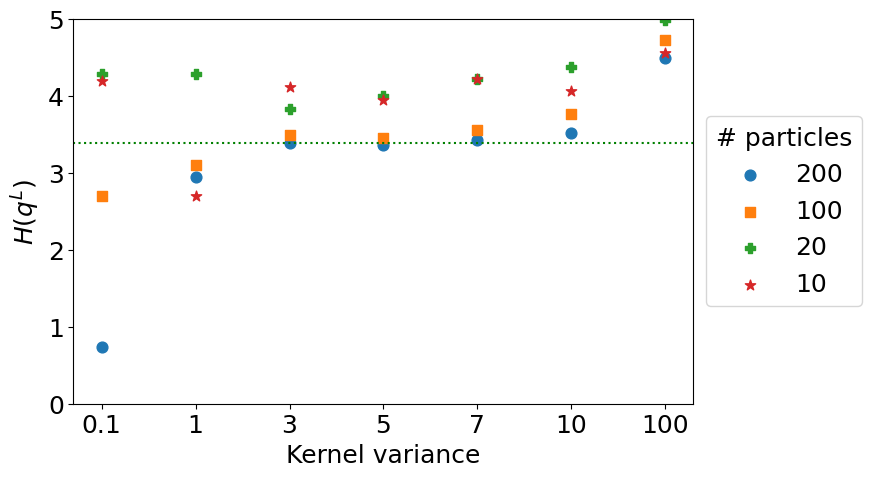

In [ ]:
# Weather to use the GMM class or not (Figure 4a: gmm == False)
dist_type = 'gmm'
# Dimension of the particles
dim = 2
# Learning Rate
lr = 0.5
# Number of mixture components
n_gmm = 1
# Target distribution's standard deviation, means are computed automatically
gmm_std = 1
# A list contaning number of steps and number of particles
num_particles_steps = [[10, [20, 20, 20]], [20, [20, 20, 20]], [100, [100, 20, 20]], [200, [200, 20, 20]]]
# A list of Kernel variances
kernel_variance = [0.1, 1, 3, 5, 7, 10, 100]
# A list containing the mean and the strandard deviation for multiple initial distributions
mu_sigma_init = [[0, 6], [4, 0.2]]
# Standard deviation of the initial distribution HMC
sigma_V_init = 2
# Dictionary used to select whare algorithms to run
run_alg = {'svgd':True, 'ld':True, 'dld':True, 'hmc':True}

# Run the experiments or load the data
load_data = True

if not load_data:
    # Run multiple experiments according to the arguments above and save all the resulting data in results.pickle
    results = {}
    for attr in ['configs', 'init_chart', 'sampler_entr_svgd', 'sampler_entr_ld', 'gt_entr', 'charts_svgd', 'charts_ld']:
        results[attr] = []


    for k in tqdm(range(len(mu_sigma_init)), desc='mu_sigma_init'):
        for i in tqdm(range(len(num_particles_steps)), desc='num_particles_steps'):
            for j in range(len(kernel_variance)):
                results['configs'].append([dim, lr, n_gmm, gmm_std, num_particles_steps[i][0], num_particles_steps[i][1], kernel_variance[j], mu_sigma_init[k][0], mu_sigma_init[k][1]])
                print('config: ', results['configs'][-1])
                init_chart, sampler_entr_svgd, sampler_entr_ld, sampler_entr_hmc, sampler_entr_dld, gt_entr, charts_svgd, charts_ld, charts_hmc, charts_dld = my_experiment(dim, n_gmm, num_particles_steps[i][0], num_particles_steps[i][1], kernel_variance[j], gmm_std, lr, mu_sigma_init[k][0], mu_sigma_init[k][1], sigma_V_init, dist_type, run_alg)

                results['init_chart'].append(init_chart)
                results['sampler_entr_svgd'].append(sampler_entr_svgd)
                results['sampler_entr_ld'].append(sampler_entr_ld)
                results['gt_entr'].append(gt_entr)
                results['charts_svgd'].append(charts_svgd)
                results['charts_ld'].append(charts_ld)
            
    with open('results.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('results_special2.pickle', 'rb') as handle:
        results = pickle.load(handle)



# Generate figure 4c for initial distribution N(0, 6)
figure_4b(results, 0, 6, 'figure_4c_1')




### Figure 4b

In [20]:

# Weather to use the GMM class or not (Figure 4a: gmm == False)
dist_type = 'gmm'
# Learning Rate
lr = 0.5
# List containing multiple number of update steps and number of particles
# num_particles_steps = [[10,[20, 20, 20]], [10, [10, 20, 20]], [200, [200, 20, 20]], [200, [500, 20, 20]]]
num_particles_steps = [[10, [50, -1, -1]]]
# Kernel Variance
# kernel_variance = 'forth'
kernel_variance = 'forth'
# Mean and standard deviation of the initial distribution
mu_sigma_init = [0, 6]
# Standard deviation of the initial distribution HMC
sigma_V_init = 2
# Dimension of the particles
# dims = [2, 10, 20, 100]
dims = [10]
# dims = [2]
# A list containing multiple Number of mixtures
n_gmms = [1, 2, 4, 6]
# A list Containing multiple target distribution's standard deviations
gmm_std = [0.5, 1.0, 2, 5]
# Dictionary used to select whare algorithms to run
run_alg = {'svgd':True, 'ld':False, 'dld':False, 'hmc':False}

# Do the experiments or load the data
load_data = False

if not load_data:
    # Do multiple experiments according to the arguments above and save all the resulting data in results_dim.pickle
    results = []
    for seed in range(5):
        results.append({})


        for expr in ['gmm_expr', 'var_expr']:
            results[-1][expr] = {}
            for attr in ['configs', 'init_chart', 'sampler_entr_svgd', 'sampler_entr_ld', 'gt_entr', 'charts_svgd', 'charts_ld']:
                results[-1][expr][attr] = []

        torch.manual_seed(seed)
        np.random.seed(seed)
        
        def particles_steps_loop(results, expr, dim, lr, n_gmm, gmm_std, num_particles_steps, kernel_variance, mu_sigma_init):
            for i in range(len(num_particles_steps)):
                results[-1][expr]['configs'].append([dim, lr, n_gmm, gmm_std, num_particles_steps[i][0], num_particles_steps[i][1], kernel_variance, mu_sigma_init[0], mu_sigma_init[1]])
                # print('config: ', results[-1][expr]['configs'][-1])

                init_chart, sampler_entr_svgd, sampler_entr_ld, sampler_entr_hmc, sampler_entr_dld, gt_entr, charts_svgd, charts_ld, charts_hmc, charts_dld = my_experiment(dim, n_gmm, num_particles_steps[i][0], num_particles_steps[i][1], kernel_variance, gmm_std, lr, mu_sigma_init[0], mu_sigma_init[1], sigma_V_init, dist_type, run_alg)

                results[-1][expr]['init_chart'].append(init_chart)
                results[-1][expr]['sampler_entr_svgd'].append(sampler_entr_svgd)
                results[-1][expr]['sampler_entr_ld'].append(sampler_entr_ld)
                results[-1][expr]['gt_entr'].append(gt_entr)
                results[-1][expr]['charts_svgd'].append(charts_svgd)
                results[-1][expr]['charts_ld'].append(charts_ld)
            return results 

        # for dim in tqdm(dims, desc='GMM'):
        #     for n_gmm in n_gmms:
        #         results = particles_steps_loop(results, 'gmm_expr', dim, lr, n_gmm, 1, num_particles_steps, kernel_variance, mu_sigma_init)

        for dim in tqdm(dims, desc='VAR'):
            for std in gmm_std:
                results = particles_steps_loop(results, 'var_expr', dim, lr, 1, std, num_particles_steps, kernel_variance, mu_sigma_init)
            
    with open('results_dim.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('results_dim_tmp.pickle', 'rb') as handle:
            results_tmp = pickle.load(handle)
    with open('results_dim_gmm200.pickle', 'rb') as handle:
            results_gmm_200 = pickle.load(handle)
    with open('results_dim_gmm500.pickle', 'rb') as handle:
            results_gmm_500 = pickle.load(handle)
    with open('results_dim_var200.pickle', 'rb') as handle:
            results_var_200 = pickle.load(handle)
    with open('results_dim_var500.pickle', 'rb') as handle:
            results_var_500 = pickle.load(handle)

    with open('results_dim_2d.pickle', 'rb') as handle:
        results = pickle.load(handle)


# filtered_results = [filter(results[i]['gmm_expr'], [dim, '*', '*', '*', 10, [10, -1, -1], '*' , 0, 6]) for i in range(len(results))]

# Generate figure 6a along with the same figure for other high dimensions 
# figure_6(results, [2], 'gmm_expr', 'Number of mixures', ['1', '2', '4', '6'], results_tmp=results_tmp, results_200=results_gmm_200, results_500=results_gmm_500)
# Generate figure 6b along with the same figure for other high dimensions 
# figure_6(results, [2, 10, 20, 100], 'var_expr', 'Gaussian Distribution Variance', ['0.5', '1.0', '2.0', '5.0'], results_tmp=results_tmp)


VAR:   0%|          | 0/1 [00:00<?, ?it/s]

################# score_func:  8.459091e-06
################# diff X_t X_t-1:  0.00081969256
################# score_func:  -0.047500838
################# diff X_t X_t-1:  0.2606505
################# score_func:  0.010520143
################# diff X_t X_t-1:  0.03473884


VAR:   0%|          | 0/1 [00:00<?, ?it/s]

################# score_func:  0.000598639
################# diff X_t X_t-1:  0.028171591
################# score_func:  2.0182728e-05
################# diff X_t X_t-1:  0.0013993941
################# score_func:  0.042150367
################# diff X_t X_t-1:  0.25059658
################# score_func:  -0.0005158777
################# diff X_t X_t-1:  0.038966507


VAR:   0%|          | 0/1 [00:00<?, ?it/s]

################# score_func:  0.0023761601
################# diff X_t X_t-1:  0.022653935
################# score_func:  1.0101795e-05
################# diff X_t X_t-1:  0.016326074
################# score_func:  0.035981808
################# diff X_t X_t-1:  0.25259113
################# score_func:  0.0015233654
################# diff X_t X_t-1:  0.04642998


VAR:   0%|          | 0/1 [00:00<?, ?it/s]

################# score_func:  -0.0026814037
################# diff X_t X_t-1:  0.028992616
################# score_func:  -8.0582495e-06
################# diff X_t X_t-1:  0.0071237385
################# score_func:  0.019076927
################# diff X_t X_t-1:  0.25875017
################# score_func:  0.011119082
################# diff X_t X_t-1:  0.04722305


VAR:   0%|          | 0/1 [00:00<?, ?it/s]

################# score_func:  -0.0015668462
################# diff X_t X_t-1:  0.021615133
################# score_func:  3.9613246e-06
################# diff X_t X_t-1:  0.00030737152
################# score_func:  0.019007895
################# diff X_t X_t-1:  0.23783214
################# score_func:  -0.004682346
################# diff X_t X_t-1:  0.03849222


VAR: 100%|██████████| 1/1 [00:14<00:00, 14.44s/it]

################# score_func:  0.0047103856
################# diff X_t X_t-1:  0.022891104


In [21]:
# filtered_results = [filter(results[i]['gmm_expr'], [dim, '*', '*', '*', 10, [20, -1, -1], '*' , 0, 6]) for i in range(len(results))]
# gmm1_10s_10p = [filtered_results[i][0] for i in range(len(filtered_results))]
# print(np.array(gmm1_10s_10p).mean(0))
filtered_results = [filter(results[i]['var_expr'], [dim, '*', '*', '*', 10, [50, -1, -1], '*' , 0, 6]) for i in range(len(results))]
gmm1_10s_10p = [filtered_results[i][0] for i in range(len(filtered_results))]
print(np.array(gmm1_10s_10p).mean(0))

[20.73114243 25.13680878 26.04444962 25.73302422]


/tmp/ipykernel_736370/1047997967.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results['sampler_entr_svgd'])[configs].tolist(), np.array(results['gt_entr'])[configs].tolist(), np.array(results['charts_svgd'])[configs].tolist(), np.array(results['init_chart'])[configs].tolist()


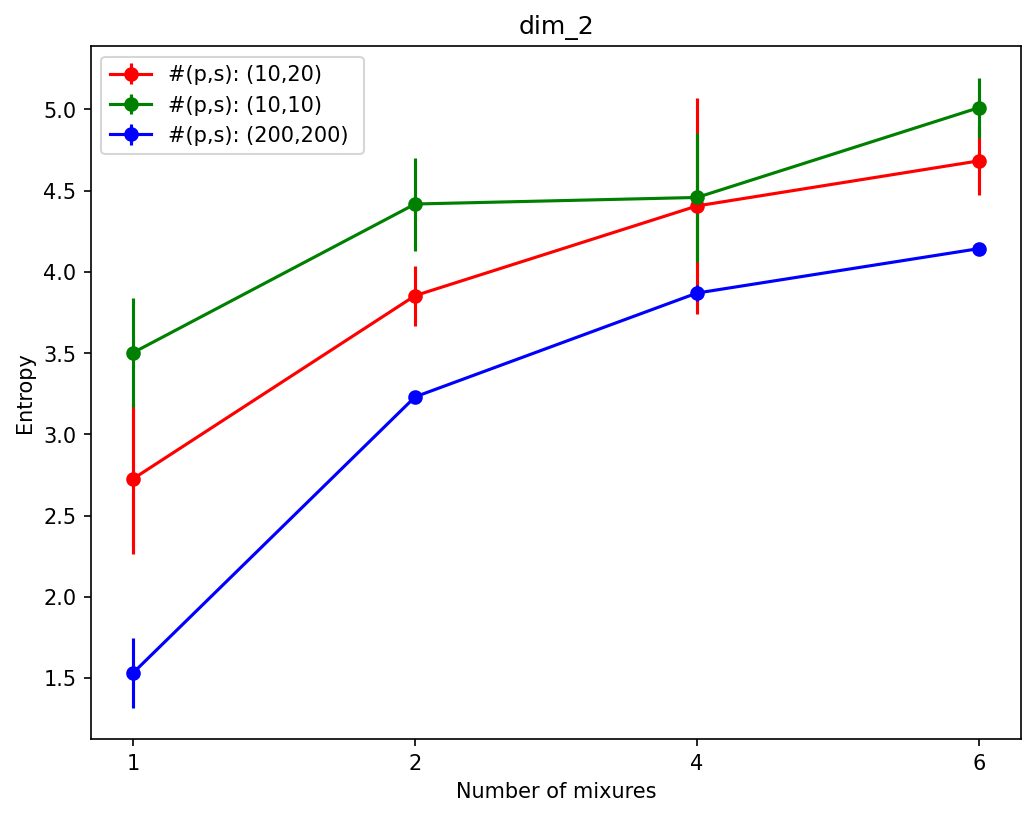

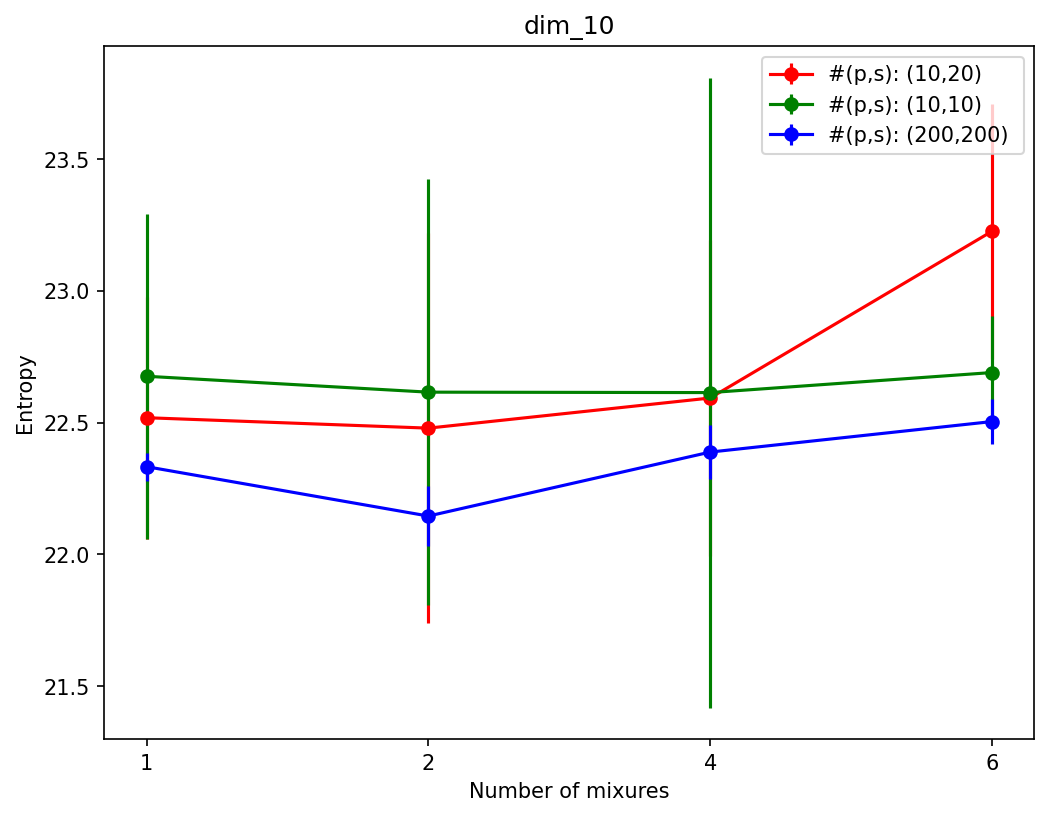

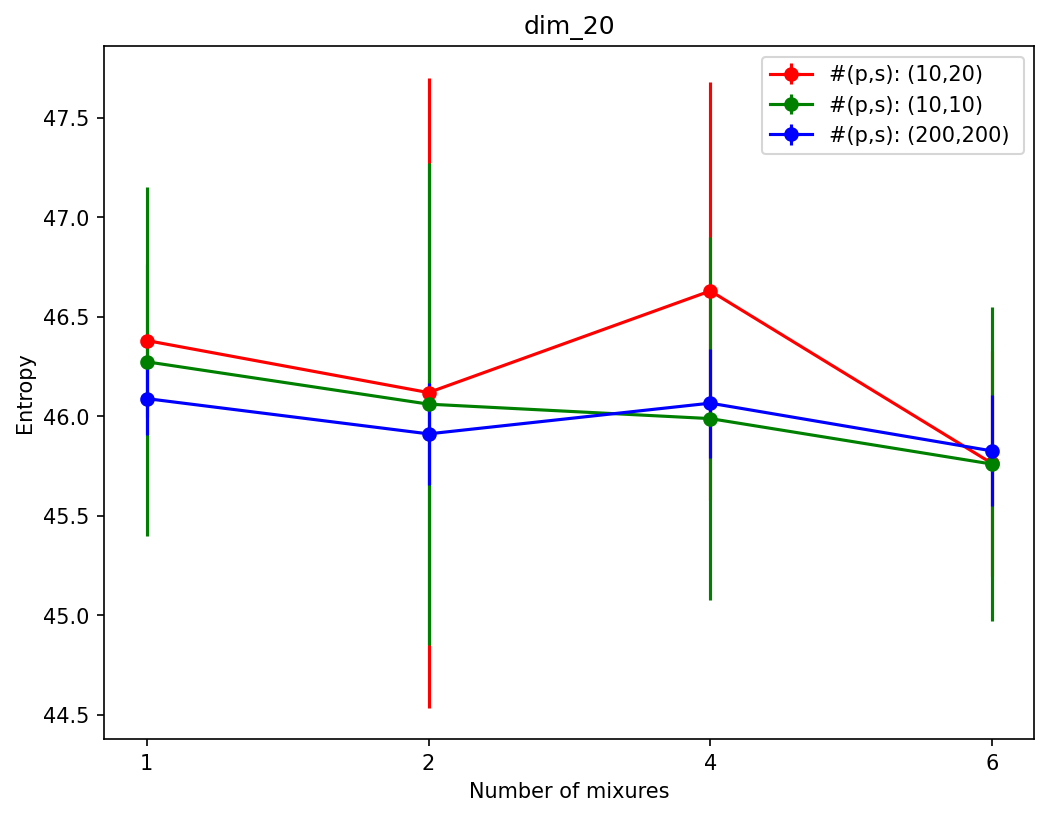

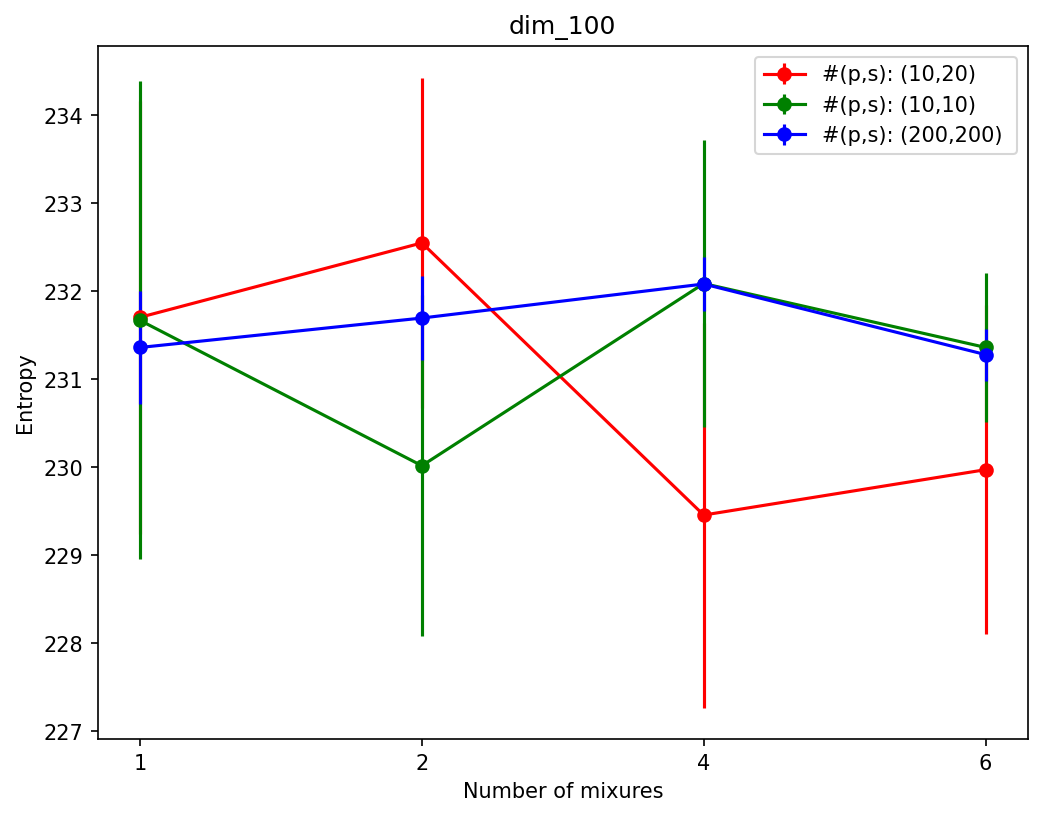

In [12]:

with open('results_dim_1020_.pickle', 'rb') as handle:
            results_1020 = pickle.load(handle)

with open('results_dim_gmm200.pickle', 'rb') as handle:
            results_gmm_200 = pickle.load(handle)

with open('results_dim_var200.pickle', 'rb') as handle:
            results_var_200 = pickle.load(handle)


def figure_4b(results, dims, expr_name, x_label, x_ticks, results_1020=None, results_200=None, results_500=None):
    """
    Create figure 6 from the paper
    Inputs:
        results: Dictionary containing all the results' data
        dims: A list containing the dimensions we want to print
        expr_name: Experiment name
        x_label: X axis label
        x_ticks: X axis ticks
    """

    for dim in dims:
        filtered_results = [filter(results_1020[i][expr_name], [dim, '*', '*', '*', 10, [20,-1,-1], '*' , 0, 6]) for i in range(len(results_1020))]
        gmm1_20s_10p = [filtered_results[i][0] for i in range(len(filtered_results))]

        filtered_results = [filter(results_1020[i][expr_name], [dim, '*', '*', '*', 10, [10,-1,-1], '*' , 0, 6]) for i in range(len(results_1020))]
        gmm1_10s_10p = [filtered_results[i][0] for i in range(len(filtered_results))]

   
        filtered_results = [filter(results_200[i][expr_name], [dim, '*', '*', '*', 200, [200,-1,-1], '*' , 0, 6]) for i in range(len(results_200))]
        gmm1_200s_200p = [filtered_results[i][0] for i in range(len(filtered_results))]

        # if results_500 == None:
        #     filtered_results = [filter(results[i][expr_name], [dim, '*', '*', '*', 200, 500, '*' , 0, 6]) for i in range(len(results))]
        # else:
        #     filtered_results = [filter(results_500[i][expr_name], [dim, '*', '*', '*', 200, [500,20,20], '*' , 0, 6]) for i in range(len(results_500))]
        # gmm1_500s_200p = [filtered_results[i][0] for i in range(len(filtered_results))]
        
        
        # raw_mean = [list(np.nanmean(gmm1_20s_10p, axis=0)), list(np.nanmean(gmm1_10s_10p, axis=0)), list(np.nanmean(gmm1_200s_200p, axis=0)), list(np.nanmean(gmm1_500s_200p, axis=0))]
        # raw_std = [list(np.nanstd(gmm1_20s_10p, axis=0)), list(np.nanstd(gmm1_10s_10p, axis=0)), list(np.nanstd(gmm1_200s_200p, axis=0)), list(np.nanstd(gmm1_500s_200p, axis=0))]
        raw_mean = [list(np.nanmean(gmm1_20s_10p, axis=0)), list(np.nanmean(gmm1_10s_10p, axis=0)), list(np.nanmean(gmm1_200s_200p, axis=0))]
        raw_std = [list(np.nanstd(gmm1_20s_10p, axis=0)), list(np.nanstd(gmm1_10s_10p, axis=0)), list(np.nanstd(gmm1_200s_200p, axis=0))]

        colors = ['r', 'g', 'b', 'k']
        # labels = ['#(p,s): (10,20) ', '#(p,s): (10,10) ', '#(p,s): (200,200) ', '#(p,s): (200,500) ']
        labels = ['#(p,s): (10,20) ', '#(p,s): (10,10) ', '#(p,s): (200,200) ']
        plt.figure(figsize=(8, 6), dpi=150)
        plt.xlabel(x_label)
        plt.ylabel("Entropy")
        for i in range(len(raw_mean)):
            plt.errorbar(np.array([0.0, 1.0, 2.0, 3.0]), raw_mean[i], yerr=raw_std[i], color=colors[i], marker='o', label=labels[i])
        plt.xticks(np.array([0.0, 1.0, 2.0, 3.0]), np.array(x_ticks))
        # plt.xlim([-0.5, 3.5])
        plt.title('dim_' + str(dim))
        plt.legend()
        plt.savefig('./' + expr_name + '_' + str(dim) + '.png', bbox_inches='tight')




figure_4b(None, [2, 10, 20, 100], 'gmm_expr', 'Number of mixures', ['1', '2', '4', '6'], results_1020=results_1020, results_200=results_gmm_200, results_500=None)


In [25]:
# print(np.array(results_var_1020[-1]['gmm_expr']['configs']))
# print(np.array(results_var_1020[-1]['var_expr']['configs']))
# print(np.array(results_var_20[-1]['gmm_expr']['configs']))
# print(np.array(results_var_20[-1]['var_expr']['configs']))
# print(np.array(results_var_10[-1]['gmm_expr']['configs']))
# print(np.array(results_var_10[-1]['var_expr']['configs']))
# print(np.array(results_var_1[-1]['gmm_expr']['configs']))
# print(np.array(results_var_1[-1]['var_expr']['configs']))
# print(np.array(results_var_1020[-1]['gmm_expr']['sampler_entr_svgd']))
# print(np.array(results_var_1020[-1]['var_expr']['sampler_entr_svgd']))
print(np.array(results_var_20__[0]['gmm_expr']['sampler_entr_svgd']))
# print(np.array(results_var_20[-1]['var_expr']['sampler_entr_svgd']))
print(np.array(results_var_10__[0]['gmm_expr']['sampler_entr_svgd']))
# print(np.array(results_var_10[-1]['var_expr']['sampler_entr_svgd']))
# print(np.array(results_var_1[-1]['gmm_expr']['sampler_entr_svgd']))
# print(np.array(results_var_1[-1]['var_expr']['sampler_entr_svgd']))


[4.92813873]
[4.92813873]


In [19]:
# Weather to use the GMM class or not (Figure 4a: gmm == False)
dist_type = 'gmm'
# Dimension of the particles
dim = 2
# Learning Rate
lr = 0.5
# Number of mixtures
n_gmm = 1
# Target distribution's standard deviation, means are computed automatically
gmm_std = 1
# Number of particles
num_particles = 10
# Number of update steps
num_steps = [10, -1, -1]
# Kernel variance
kernel_variance = 'forth'
# Standard deviation of the initial distribution HMC
sigma_V_init = 1
# Dictionary used to select whare algorithms to run
run_alg = {'svgd':True, 'ld':False, 'dld':False, 'hmc':False}


# [2 0.5 1 1 10 list([20, -1, -1]) 'forth' 0 6]
# [2 0.5 1 1 10 list([10, -1, -1]) 'forth' 0 6]
seed = 0

# Mean of the initial distribution
mu_init = 0
# Standard deviation of the initial distribution
sigma_init = 6
# Do one experiment for initial distribution N(0, 6)
init_chart, sampler_entr_svgd, sampler_entr_ld, sampler_entr_hmc, sampler_entr_dld, gt_entr, charts_svgd, charts_ld, charts_hmc, charts_dld = my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)
print(sampler_entr_svgd)


num_steps = [20, -1, -1]
init_chart, sampler_entr_svgd, sampler_entr_ld, sampler_entr_hmc, sampler_entr_dld, gt_entr, charts_svgd, charts_ld, charts_hmc, charts_dld = my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)
print(sampler_entr_svgd)


entropy gt (logp):  1.9764056205749512

___________SVGD___________
9  entropy svgd (line 1):  4.37562894821167
9  entropy svgd (line 2):  4.439441204071045
4.928138732910156
entropy gt (logp):  1.9764056205749512

___________SVGD___________
19  entropy svgd (line 1):  3.055427312850952
19  entropy svgd (line 2):  3.1953043937683105
4.928138732910156
